# CIFAR-10 classification
## 1. Baseline
### 1.1.  import libraries and define hyperparameters

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import random
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from vit_pytorch import ViT

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

In [3]:
device = 'cuda'

In [4]:
batch_size = 64
epochs = 5
lr = 3e-5
gamma = 0.7

### 1.2. load and normalize CIFAR-10

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform_train)
trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's view some of the pictures

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


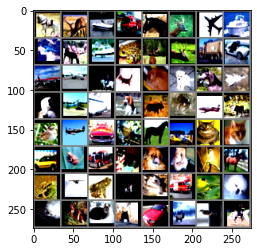

In [7]:
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### 1.3. define a transformer

In [9]:
model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim = 128,
    depth = 8,
    heads = 8,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.
).to(device)

### 1.4. Let's start our training!

In [10]:
# loss function
criterion = torch.nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=gamma)

In [11]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    print("current lr = %lf"%optimizer.param_groups[0]['lr'])

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    
    #scheduler.step()

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

current lr = 0.000030



Epoch : 1 - loss : 1.9892 - acc: 0.2585 - val_loss : 1.8700 - val_acc: 0.3137

current lr = 0.000030



Epoch : 2 - loss : 1.7749 - acc: 0.3489 - val_loss : 1.6907 - val_acc: 0.3886

current lr = 0.000030



Epoch : 3 - loss : 1.6377 - acc: 0.4012 - val_loss : 1.5824 - val_acc: 0.4300

current lr = 0.000030



Epoch : 4 - loss : 1.5600 - acc: 0.4355 - val_loss : 1.5488 - val_acc: 0.4365

current lr = 0.000030



Epoch : 5 - loss : 1.5050 - acc: 0.4531 - val_loss : 1.5007 - val_acc: 0.4545



In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


In [12]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [18]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>